## Implementasi Metode VADER-LSTM dalam Pengujian Pengaruh Sentimen Investor terhadap Prediksi Harga Saham

In [1]:
import math
import nltk
import unicodedata
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as dt
from matplotlib.dates import DateFormatter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras import models as md
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ravie\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ravie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ravie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import tensorflow as tf
tf.version.VERSION

In [ ]:
company = "TSLA"

### Importing Tweet Data

In [ ]:
all_tweets = pd.read_csv("stock_tweets.csv")
print(all_tweets.shape)
all_tweets

In [ ]:
tweet_df = all_tweets[all_tweets['Stock Name'] == company]
tweet_df = tweet_df.drop(['Company Name', 'Stock Name'], axis=1)
tweet_df['Date'] = pd.to_datetime(tweet_df['Date']).dt.date
tweet_df

#### Pre-processing the tweets

In [ ]:
processed_df = tweet_df.copy()
processed_df

In [ ]:
def preprocess_tweet(tweet):
    '''
    Takes a tweet as an input and output the list of tokens.
    '''
    
    import emoji
    import re
    from nltk import word_tokenize
    from nltk.corpus import stopwords
    from nltk.stem import PorterStemmer
    
    # Initialization
    new_tweet = tweet
    
    ## Changes on string
    
    # Remove urls
    new_tweet = re.sub(r'https?://[^ ]+', '', new_tweet)
    
    # Remove usernames
    new_tweet = re.sub(r'@[^ ]+', '', new_tweet)
    
    # Remove hashtags
    new_tweet = re.sub(r'#', '', new_tweet)
    
    # Character normalization
    new_tweet = re.sub(r'([A-Za-z])\1{2,}', r'\1', new_tweet)
    
    # Emoji transformation
    new_tweet = emoji.demojize(new_tweet)
    
    # Punctuation and special characters
    new_tweet = re.sub(r' 0 ', 'zero', new_tweet)
    new_tweet = re.sub(r'[^A-Za-z ]', '', new_tweet)
    
    # Lower casing
    new_tweet = new_tweet.lower()
    
    
    ## Changes on tokens
    
    # Tokenization
    tokens = word_tokenize(new_tweet)
    
    porter = PorterStemmer()

    for token in tokens:
        # Stopwords removal
        if token in stopwords.words('english'):
            tokens.remove(token)
        # Stemming
        token = porter.stem(token)
    
    return ' '.join(tokens)
    # return tokens

In [ ]:
for indx, row in processed_df.T.items():
    try:
        processed_df.at[indx, 'Tweet'] = preprocess_tweet(processed_df.at[indx, 'Tweet'])
    except TypeError:
        break

In [ ]:
processed_df.to_csv('tweet_processed.csv', index=False)

#### Labeling the tweets with VADER

In [ ]:
processed_df = pd.read_csv('tweet_processed.csv')
processed_df['Date'] = pd.to_datetime(processed_df['Date'])
processed_df['Tweet'] = processed_df['Tweet'].astype(str)
processed_df['Date'] = pd.to_datetime(processed_df['Date'])
processed_df

In [ ]:
sentiment_analyzer = SentimentIntensityAnalyzer()
for indx, row in processed_df.T.items():
    try:
        sentence_sentiment = sentiment_analyzer.polarity_scores(processed_df.loc[indx, 'Tweet'])
        processed_df.at[indx, 'Negative'] = sentence_sentiment['neg']
        processed_df.at[indx, 'Neutral'] = sentence_sentiment['neu']
        processed_df.at[indx, 'Positive'] = sentence_sentiment['pos']
        processed_df.at[indx, 'Compound'] = sentence_sentiment['compound']
    except TypeError:
        print (processed_df.loc[indx, 'Tweet'])
        print (indx)
        break

In [ ]:
processed_df.to_csv('tweet_processed_labeled.csv', index=False)

In [ ]:
processed_df = pd.read_csv('tweet_processed_labeled.csv')
processed_df['Date'] = pd.to_datetime(processed_df['Date'])
processed_df['Date'] = processed_df['Date'].dt.date
processed_df

In [ ]:
labeled_tweets_df = processed_df.copy()

for indx, row in processed_df.T.items():
    if (processed_df.at[indx, 'Compound'] > 0.5):
        labeled_tweets_df.at[indx, 'Sentiment'] = 'Positive'
    elif (processed_df.at[indx, 'Compound'] < -0.5):
        labeled_tweets_df.at[indx, 'Sentiment'] = 'Negative'
    else:
        labeled_tweets_df.at[indx, 'Sentiment'] = 'Neutral'

In [ ]:
labeled_tweets_df

In [ ]:
fig, ax = plt.subplots()
bar_colors = ['grey', 'green', 'red']
ax.bar(['Neutral', 'Positive', 'Negative'], labeled_tweets_df['Sentiment'].value_counts(), color=bar_colors)
ax.set(xlabel="Sentimen", ylabel="Count", title=f"{company} Sentiment Result")

plt.show()

In [ ]:
daily_sentiments_df = labeled_tweets_df.groupby([labeled_tweets_df['Date']]).mean(numeric_only=True)
daily_sentiments_df

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(daily_sentiments_df['Compound'], color='#008B8B')
ax.set(xlabel="Date", ylabel="Sentiment", title=f"{company} Daily Sentiment")
ax.xaxis.set_major_locator(dt.MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
plt.show()

#### Grouping sentiments by day

In [ ]:
daily_sentiments_df = processed_df.groupby([processed_df['Date']]).mean(numeric_only=True)
daily_sentiments_df

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(daily_sentiments_df['Compound'], color='#008B8B')
ax.set(xlabel="Date", ylabel="Score", title=f"{company} Daily Sentiment")
ax.xaxis.set_major_locator(dt.MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
plt.show()

### Importing Stock Data

In [ ]:
all_stocks = pd.read_csv("stock_yfinance_data.csv")
all_stocks

In [ ]:
stock_df = all_stocks[all_stocks['Stock Name'] == company]
stock_df = stock_df.drop('Stock Name', axis=1)
stock_df['Date'] = pd.to_datetime(stock_df['Date']).dt.date
stock_df = stock_df.set_index("Date")
stock_df

In [ ]:
stock_df.dropna()

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(stock_df['Close'], color='#008B8B')
ax.set(xlabel="Date", ylabel="USD", title=f"{company} Stock Price")
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
plt.show()

In [ ]:
dataset_df = stock_df.copy()
dataset_df = dataset_df.join(daily_sentiments_df, how="left", on="Date")
dataset_df

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset_df[['Close', 'Compound']].values)

fig, ax = plt.subplots()
ax.plot(scaled_data, label=["Closing Price", 'Sentiment'])
ax.set(xlabel="Date", ylabel="Scaled Data", title=f"{company} Scaled Price Overlaid with Daily Sentiment")
ax.legend()
# ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
plt.show()

### Functions

In [ ]:
def SplitData(data, train_size, timestep):
    data_values = data.values
    training_data_len = math.ceil(len(data)* train_size)

    scaler = MinMaxScaler(feature_range=(0,1))
    if (len(data_values.shape) == 1):
        scaled_data = scaler.fit_transform(data_values.reshape(-1,1))
    else:
        scaled_data = scaler.fit_transform(data_values)
        scaled_index = scaler.fit_transform(data_values[:, 0:1].flatten().reshape(-1,1))

    train_data = scaled_data[0: training_data_len, :]
    test_data = scaled_data[training_data_len-timestep: , :]

    train_data_x = train_data[0: training_data_len, :]
    train_data_y = train_data[0: training_data_len, 0:1]

    x_train = []
    y_train = []

    for i in range(timestep, len(train_data_x)):
        x_train.append(train_data_x[i-timestep:i])
        y_train.append(train_data_y[i][0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))

    test_data = scaled_data[training_data_len-timestep: , : ]
    x_test = []
    if (len(data_values.shape) == 1):
        y_test = data_values[training_data_len:]
    else:
        y_test = data_values[training_data_len: , 0]

    for i in range(timestep, len(test_data)):
        x_test.append(test_data[i-timestep:i])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

    return x_train, y_train, x_test, y_test, scaler

In [ ]:
def TrainModel(x_data, y_data, epoch):

    regressor = Sequential()
    regressor.add(LSTM(units=64, return_sequences=True, input_shape=(x_data.shape[1], x_data.shape[2])))
    regressor.add(Dropout(0.2))

    regressor.add(LSTM(units=64, return_sequences=False))
    regressor.add(Dropout(0.2))

    regressor.add(Dense(units=1, activation='linear'))

    regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
    history = regressor.fit(x_data, y_data, batch_size=1, epochs=epoch, validation_split=0.2)

    return regressor, history

In [ ]:
def PlotTrainingMetrics(history):
    history_data = history.history
    
    loss_values = history_data['loss']
    val_loss_values = history_data['val_loss']
    mae_values = history_data['mae']
    val_mae_values = history_data['val_mae']
    rmse_values = np.sqrt(history_data['loss'])
    val_rmse_values = np.sqrt(history_data['val_loss'])
    epochs = range(1, len(loss_values) + 1)

    fig = plt.figure(figsize=(16, 8))
    gs = fig.add_gridspec(1, 3, wspace=0)
    (ax1, ax2, ax3) = gs.subplots(sharey=True)
    fig.suptitle('Training and validation metrics')
    fig.supxlabel('epochs')

    ax1.plot(epochs, mae_values, color = 'blue', label='Training MAE')
    ax1.plot(epochs, val_mae_values, color='red', label='Validation MAE')
    ax1.set_title('MAE')
    ax1.set_xticks(epochs)
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(len(loss_values)/5))
    ax1.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax1.xaxis.grid(True, which='both', alpha=0.5)
    ax1.yaxis.grid(True, alpha=0.5)
    ax1.set_ylabel('value')
    ax1.legend()

    ax2.plot(epochs, loss_values, color = 'blue', label='Training loss')
    ax2.plot(epochs, val_loss_values, color='red', label='Validation loss')
    ax2.set_title('Loss (MSE)')
    ax2.set_xticks(epochs)
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(len(loss_values)/5))
    ax2.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax2.xaxis.grid(True, which='both', alpha=0.5)
    ax2.yaxis.grid(True, alpha=0.5)
    ax2.legend()

    ax3.plot(epochs, rmse_values, color = 'blue', label='Training RMSE')
    ax3.plot(epochs, val_rmse_values, color='red', label='Validation RMSE')
    ax3.set_title('RMSE')
    ax3.set_xticks(epochs)
    ax3.xaxis.set_major_locator(ticker.MultipleLocator(len(loss_values)/5))
    ax3.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax3.xaxis.grid(True, which='both', alpha=0.5)
    ax3.yaxis.grid(True, alpha=0.5)
    ax3.legend()

In [ ]:
def PlotPredictions(data, prediction):
    train_plot = data[:len(data)-len(prediction)]
    validation_plot = data[len(data)-len(prediction):].copy()
    validation_plot['Predictions'] = prediction

    fig, ax = plt.subplots(figsize=(16, 8))
    ax.set_title('Model and Predictions')
    ax.set_ylabel('Closing price (USD)')
    ax.set_xlabel('Date')
    ax.plot(train_plot)
    ax.plot(validation_plot[['Close', 'Predictions']])
    ax.xaxis.set_major_locator(dt.MonthLocator())
    ax.xaxis.set_minor_locator(dt.MonthLocator(bymonthday=15))
    ax.xaxis.set_major_formatter(dt.DateFormatter('%b'))
    ax.grid(alpha=0.5, which='both')
    ax.legend(['Train', 'Validation', 'Predictions'])

### LSTM without Sentiment Score

In [ ]:
close_prices = dataset_df['Close']

train_portion = 0.8
timestep = 60


x_train, y_train, x_test, y_test, scaler = SplitData(close_prices, train_portion, timestep)

In [ ]:
singleModel, history_single = TrainModel(x_train, y_train, 10)

In [ ]:
singleModel.save('saved_model/single-features.h5')

In [ ]:
singleModel = md.load_model('saved_model/single-features.h5')

In [ ]:
singleModel.get_weights()

In [ ]:
singleModel.summary()

In [ ]:
predictions_single = singleModel.predict(x_test)
predictions_single = scaler.inverse_transform(predictions_single)

mae = np.mean(np.abs(predictions_single - y_test))
mse = np.mean((predictions_single - y_test)**2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - predictions_single)/y_test)) * 100
mae, mse, rmse, mape

In [ ]:
PlotTrainingMetrics(history_single)

In [ ]:
PlotPredictions(dataset_df.filter(['Close']), predictions_single)

### LSTM with User Sentiment Score

In [ ]:
combined_data = dataset_df[['Close', 'Compound']].copy()

train_portion = 0.8
timestep = 60

x_train, y_train, x_test, y_test, scaler = SplitData(combined_data, train_portion, timestep)

In [ ]:
sentimentModel, history_sentiment = TrainModel(x_train, y_train, 10)

In [ ]:
sentimentModel.save('saved_model/multi-features.h5')

In [ ]:
sentimentModel = md.load_model('saved_model/multi-features.h5')

In [ ]:
predictions = sentimentModel.predict(x_test)
predictions

In [ ]:
predictions = scaler.inverse_transform(predictions)
predictions

In [ ]:
mae = np.mean(np.abs(predictions - y_test))
mse = np.mean((predictions - y_test)**2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - predictions)/y_test)) * 100
mae, mse, rmse, mape

In [ ]:
PlotTrainingMetrics(history_sentiment)

In [ ]:
PlotPredictions(dataset_df.filter(['Close']), predictions)

## Fine Tuning with Grid Search

In [ ]:
def TrainModelFineTune(x_data, y_data, epoch, neuron_units):

    regressor = Sequential()
    regressor.add(LSTM(units=neuron_units, return_sequences=True, input_shape=(x_data.shape[1], x_data.shape[2])))
    regressor.add(Dropout(0.2))

    regressor.add(LSTM(units=neuron_units, return_sequences=False))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units=1, activation='linear'))

    regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    history = regressor.fit(x_data, y_data, batch_size=1, epochs=epoch, validation_split=0.2)

    return regressor, history

### Fine Tune Epochs

In [ ]:
epochs = [5, 10, 20, 30, 40, 50]

epoch_finetune_history = []
epoch_finetune_test = []

In [ ]:
combined_data = dataset_df[['Close', 'Compound']].copy()

train_portion = 0.8
timestep = 60

In [ ]:
for i in range(len(epochs)):
    
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.set_title('Loss value for ' + str(epochs[i]) + ' epochs')
    ax.set_xlabel('epochs')
    ax.set_ylabel('error value')
    ax.xaxis.grid(True, which='both', alpha=0.5)
    ax.yaxis.grid(True, alpha=0.5)

    for j in range(10):

        x_train, y_train, x_test, y_test, scaler = SplitData(combined_data, train_portion, timestep)

        start_time = time.time()
        sentimentModel, history = TrainModelFineTune(x_train, y_train, epochs[i], 32)
        end_time = time.time()
        training_time = end_time - start_time

        predictions = sentimentModel.predict(x_test)
        predictions = scaler.inverse_transform(predictions)

        mae = np.mean(np.abs(predictions - y_test))
        mse = np.mean((predictions - y_test)**2)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_test - predictions)/y_test)) * 100

        epoch_finetune_test.append([epochs[i], j, mae, mse, rmse, mape, training_time])

        history_data = history.history
    
        loss_values = history_data['loss']
        val_loss_values = history_data['val_loss']

        epoch_finetune_history.append([epochs[i], j, history_data['loss'], history_data['val_loss'], history_data['mae'], history_data['val_mae'], training_time])

        ax.plot(loss_values, color = 'blue')
        ax.plot(val_loss_values, color='red')

    plt.savefig('epoch_finetune_data/'+ str(epochs[i]) +'_epochs_diagnostic.png', facecolor=(1, 1, 1))

In [ ]:
epoch_test_finetuning = pd.DataFrame(epoch_finetune_test, columns=['#epoch', '#try', 'MAE', 'MSE', 'RMSE', 'MAPE', 'train_time'])
epoch_test_finetuning

In [ ]:
epoch_test_finetuning.to_csv('epoch_finetune_data/finetuning_test_data.csv', index=False)

In [2]:
epoch_test_finetuning = pd.read_csv('epoch_finetune_data/finetuning_test_data.csv')
epoch_test_finetuning

,#epoch,#try,MAE,MSE,RMSE,MAPE,train_time
0,5,0,16.452995,417.084625,20.422650,5.792440,27.497829
1,5,1,14.595786,337.351724,18.367137,5.085739,26.651451
2,5,2,21.534943,652.194895,25.538107,7.580885,26.448623
3,5,3,16.364322,411.876037,20.294729,5.764117,26.594965
4,5,4,16.382885,412.905221,20.320069,5.772575,30.561859
5,5,5,15.202103,357.268913,18.901558,5.198762,28.937516
6,5,6,16.426257,415.624994,20.386883,5.782871,27.776019
7,5,7,16.164125,398.580501,19.964481,5.518425,27.554009
8,5,8,17.525272,461.204532,21.475673,6.175580,27.610307
9,5,9,21.864256,677.010242,26.019420,7.695033,28.541749


In [3]:
epoch5 = epoch_test_finetuning[50:60]
epoch5.describe()

,#epoch,#try,MAE,MSE,RMSE,MAPE,train_time
count,10.0,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,50.0,4.50000,16.670705,426.711714,20.605761,5.836512,241.901400
std,0.0,3.02765,1.351747,63.002699,1.532730,0.494784,13.940568
min,50.0,0.00000,14.881234,343.470972,18.532970,5.169321,209.100802
25%,50.0,2.25000,15.516236,373.121193,19.314716,5.407902,237.469912
50%,50.0,4.50000,16.808647,431.450834,20.769464,5.893408,243.613860
75%,50.0,6.75000,17.791700,478.041037,21.862409,6.245964,251.783205
max,50.0,9.00000,18.470940,514.403258,22.680460,6.488050,257.872724


In [4]:
epoch_test_finetune_rmse = epoch_test_finetuning.pivot(index='#try', columns='#epoch', values='RMSE')
epoch_test_finetune_rmse

#epoch,5,10,20,30,40,50
#try,,,,,,
0,20.422650,21.925709,19.038973,20.986296,21.605176,22.021681
1,18.367137,20.048188,20.546504,19.931607,21.482426,19.169866
2,25.538107,19.387756,23.663993,19.450284,19.227749,22.346648
3,20.294729,18.514197,20.009697,20.767412,19.243231,18.633198
4,20.320069,21.950618,18.628566,20.048082,20.324311,22.680460
5,18.901558,19.118082,20.346684,18.930889,18.429901,21.052681
6,20.386883,21.312811,22.573524,20.893638,23.090616,18.532970
7,19.964481,19.075517,18.654510,24.572496,20.218544,19.749264
8,21.475673,18.472002,22.011396,18.993428,21.808539,21.384593


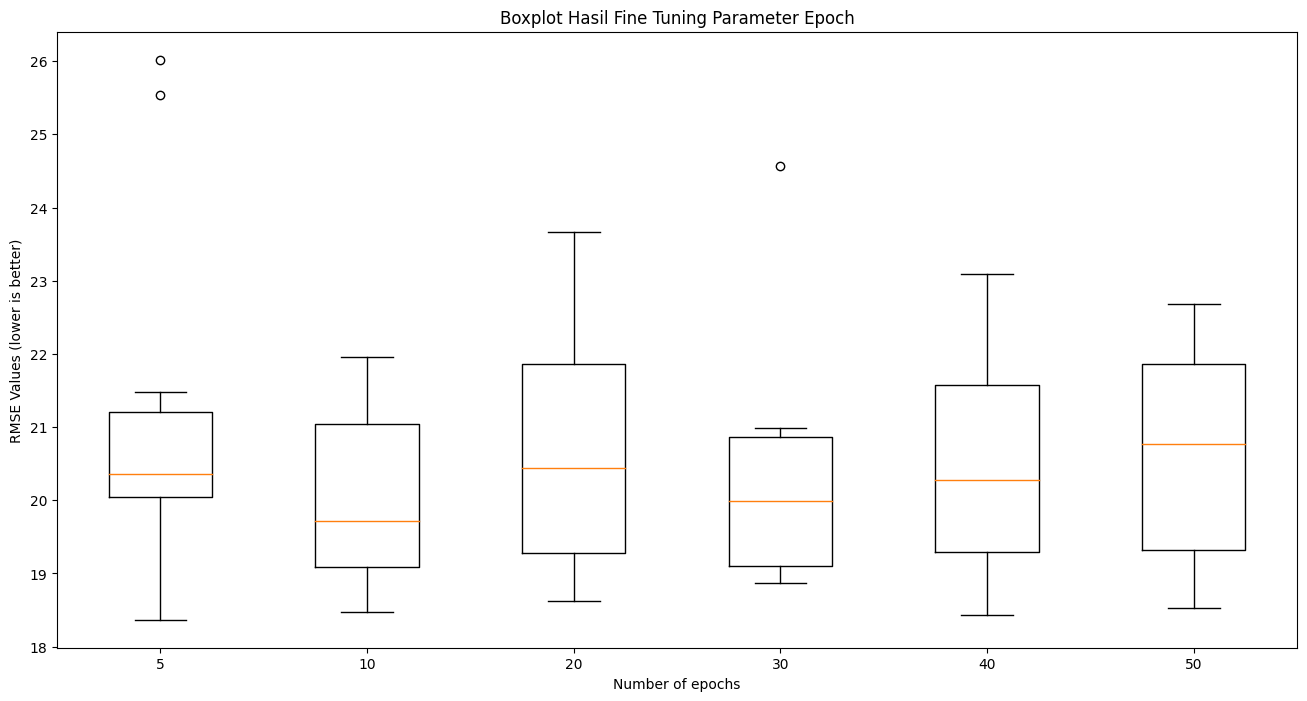

In [5]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.boxplot(epoch_test_finetune_rmse)
ax.set_xticklabels(['5', '10', '20', '30', '40', '50'])
ax.set_title("Boxplot Hasil Fine Tuning Parameter Epoch")
ax.set_xlabel('Number of epochs')
ax.set_ylabel('RMSE Values (lower is better)')
plt.savefig('epoch_finetune_data/epoch_boxplot.png', facecolor=(1, 1, 1))

In [ ]:
epoch_history_finetuning = pd.DataFrame(epoch_finetune_history, columns=['#epoch', '#try', 'loss', 'val_loss', 'mae', 'val_mae', 'train_time'])
epoch_history_finetuning

In [ ]:
epoch_history_finetuning.to_csv('neuron_finetune_data/finetuning_history_data.csv', index=False)

### Neuron Number Finetuning

In [ ]:
epoch_final = 10
neurons = [16, 32, 64, 128]

neuron_finetune_history = []
neuron_finetune_test = []

In [ ]:
combined_data = dataset_df[['Close', 'Compound']].copy()

train_portion = 0.8
timestep = 60

In [ ]:
for i in range(len(neurons)):
    
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.set_title('Loss value for ' + str(neurons[i]) + ' neurons')
    ax.set_xlabel('epochs')
    ax.set_ylabel('error value')
    ax.xaxis.grid(True, which='both', alpha=0.5)
    ax.yaxis.grid(True, alpha=0.5)

    for j in range(20):

        x_train, y_train, x_test, y_test, scaler = SplitData(combined_data, train_portion, timestep)

        start_time = time.time()
        sentimentModel, history = TrainModelFineTune(x_train, y_train, epoch_final, neurons[i])
        end_time = time.time()
        training_time = end_time - start_time

        predictions = sentimentModel.predict(x_test)
        predictions = scaler.inverse_transform(predictions)

        mae = np.mean(np.abs(predictions - y_test))
        mse = np.mean((predictions - y_test)**2)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_test - predictions)/y_test)) * 100

        neuron_finetune_test.append([neurons[i], j, mae, mse, rmse, mape, training_time])

        history_data = history.history
    
        loss_values = history_data['loss']
        val_loss_values = history_data['val_loss']

        neuron_finetune_history.append([neurons[i], j, history_data['loss'], history_data['val_loss'], history_data['mae'], history_data['val_mae'], training_time])

        ax.plot(loss_values, color = 'blue')
        ax.plot(val_loss_values, color='red')

    plt.savefig('neuron_finetune_data/'+ str(neurons[i]) +'_neuron_diagnostic.png', facecolor=(1, 1, 1))

In [ ]:
neuron_test_finetuning = pd.DataFrame(neuron_finetune_test, columns=['#neuron', '#try', 'MAE', 'MSE', 'RMSE', 'MAPE', 'train_time'])
neuron_test_finetuning

In [ ]:
neuron_test_finetuning.to_csv('neuron_finetune_data/finetuning_test_data.csv', index=False)

In [ ]:
neuron_test_finetuning = pd.read_csv('neuron_finetune_data/finetuning_test_data.csv')
neuron_test_finetuning

In [ ]:
y = neuron_test_finetuning[60:80]
y.drop(60).drop(67).drop(75).describe()

In [ ]:
neuron_test_finetune_rmse = neuron_test_finetuning.pivot(index='#try', columns='#neuron', values='RMSE')
neuron_test_finetune_rmse

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.boxplot(neuron_test_finetune_rmse)
ax.set_xticklabels(['16', '32', '64', '128'])
ax.set_title("Boxplot Hasil Fine Tuning Parameter LSTM Unit")
ax.set_xlabel('Number of neurons')
ax.set_ylabel('RMSE Values (lower is better)')
plt.savefig('neuron_finetune_data/neuron_boxplot.png', facecolor=(1, 1, 1))

In [ ]:
neuron_history_finetuning = pd.DataFrame(neuron_finetune_history, columns=['#neuron', '#try', 'loss', 'val_loss', 'mae', 'val_mae', 'train_time'])
neuron_history_finetuning

In [ ]:
neuron_history_finetuning.to_csv('neuron_finetune_data/finetuning_history_data.csv', index=False)

In [ ]:
neuron_history_finetuning = pd.read_csv('neuron_finetune_data/finetuning_history_data.csv')
neuron_history_finetuning

# COMPARE

In [ ]:
model_mode = ['single', 'combined']

compare_finetune_history = []
compare_finetune_test = []

In [ ]:
single_data = dataset_df['Close']
combined_data = dataset_df[['Close', 'Compound']].copy()

train_portion = 0.8
timestep = 60

In [ ]:
for i in range(len(model_mode)):
    
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.set_title('Loss value for ' + str(model_mode[i]) + ' mode')
    ax.set_xlabel('epochs')
    ax.set_ylabel('error value')
    ax.xaxis.grid(True, which='both', alpha=0.5)
    ax.yaxis.grid(True, alpha=0.5)

    for j in range(30):
        
        if (model_mode == 'single'):
            x_train, y_train, x_test, y_test, scaler = SplitData(single_data, train_portion, timestep)
        else:
            x_train, y_train, x_test, y_test, scaler = SplitData(combined_data, train_portion, timestep)

        start_time = time.time()
        sentimentModel, history = TrainModelFineTune(x_train, y_train, 10, 64)
        end_time = time.time()
        training_time = end_time - start_time

        predictions = sentimentModel.predict(x_test)
        predictions = scaler.inverse_transform(predictions)

        mae = np.mean(np.abs(predictions - y_test))
        mse = np.mean((predictions - y_test)**2)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_test - predictions)/y_test)) * 100

        compare_finetune_test.append([model_mode[i], j, mae, mse, rmse, mape, training_time])

        history_data = history.history
    
        loss_values = history_data['loss']
        val_loss_values = history_data['val_loss']

        compare_finetune_history.append([model_mode[i], j, history_data['loss'], history_data['val_loss'], history_data['mae'], history_data['val_mae'], training_time])

        ax.plot(loss_values, color = 'blue')
        ax.plot(val_loss_values, color='red')

    plt.savefig('compare_finetune_data/'+ str(model_mode[i]) +'_mode_diagnostic.png', facecolor=(1, 1, 1))

In [ ]:
compare_test_finetuning = pd.DataFrame(compare_finetune_test, columns=['mode', '#try', 'MAE', 'MSE', 'RMSE', 'MAPE', 'train_time'])
compare_test_finetuning

In [ ]:
compare_test_finetuning.to_csv('compare_finetune_data/finetuning_test_data.csv', index=False)

In [ ]:
compare_test_finetuning = pd.read_csv('compare_finetune_data/finetuning_test_data.csv')
compare_test_finetuning

In [ ]:
xyz = compare_test_finetuning[30:60]
xyz.describe()

In [ ]:
compare_test_finetune_rmse = compare_test_finetuning.pivot(index='#try', columns='mode', values='RMSE')
compare_test_finetune_rmse

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.boxplot(compare_test_finetune_rmse)
ax.set_xticklabels(['Combined Dataset', 'Single Dataset'])
ax.set_title("Perbandingan Model untuk Combined Dataset vs Single Dataset")
ax.set_ylabel('RMSE Values (lower is better)')
ax.grid()
plt.savefig('compare_finetune_data/comparison_boxplot.png', facecolor=(1, 1, 1))

In [ ]:
compare_history_finetuning = pd.DataFrame(compare_finetune_history, columns=['mode', '#try', 'loss', 'val_loss', 'mae', 'val_mae', 'train_time'])
compare_history_finetuning

In [ ]:
compare_history_finetuning.to_csv('compare_finetune_data/finetuning_history_data.csv', index=False)

In [ ]:
compare_history_finetuning = pd.read_csv('compare_finetune_data/finetuning_history_data.csv')
compare_history_finetuning